*Abstract*

This notebook, `spread.ipynb`, develops a pipeline to extract videos from the original YouNiverse dataset (not limited to educational content) based on a chosen topic, covering various content categories within the collection: Autos & Vehicles, Comedy, Education, Entertainment, Film & Animation, Gaming, How-to & Style, Music, News & Politics, Nonprofits & Activism, People & Blogs, Pets & Animals, Science & Technology, Sports, and Travel & Events. The extraction process relies on keyword searches in the titles and tags of the videos.

Subsequent preprocessing steps produce a pandas DataFrame containing a time series of the number of videos created, discretized on a monthly basis over the available time period. The study focuses on the top categories that account for the majority of the data (typically 90%), ensuring that the resulting plots are both comprehensible (limited to relevant and scalable categories) and based on a sufficient volume of data to support causal analyses. The period from 2015 to 2018 (inclusive) was selected for the study due to the low amount of data before 2015 and the absence of the final month of 2019, which might introduce seasonality effects and lead to misleading results.

Metrics such as noise-to-signal ratio (SNR), explained variance ratios, and autocorrelation at lag one are employed to determine the optimal time window (in months) for refining the results.

Analytical methods, including Dynamic Time Warping and Granger causality, are applied to explore the influence of Education content creation on other categories over time.

## 0. IMPORTS AND PRELIMINARY DEFINITIONS

In [ ]:
# Requirements

import gzip
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns

In [2]:
topics = {
    "datascience": ["machine learning", "deep learning", "artificial intelligence"],
    "cryptocurrency": ["crypto", "cryptocurrency", "bitcoin", "ethereum", "binance"],
    "ebola": ["ebola"],
    "terrorism": ["bin laden", "Jihadism", "Al-Qaeda"],
    "feminism": ["feminism", "metoo", "#metoo", "me too", "gender equality", "misogyny", "toxic masculinity"]
}

# 1. DATA EXTRACTION
not meant to be rerun at any time since resulting dataframes were saved \
displayed for methodology exhibition

In [3]:
def filter_jsonl(input_path, keywords, chunk_size, save_path, verbose=False):
    """Reads a JSONL file in chunks, filters rows with given keywords in title or tags, saves filtered data incrementally, and combines the results at the end.

    Args:
        input_path (str): path to yt_metadata_en.jsonl.gz
        keywords (list): list of keywords to search in title or tags
        chunk_size (int): number of lines to read per chunk
        save_path (str): path to folder where you want the batch dataframes to be saved
        verbose (bool, optional): print info. Defaults to False.
    """

    line_counter = 0
    keyword_counter = 0
    batch_index = 0

    os.makedirs(save_path, exist_ok=True)

    with gzip.open(input_path, 'rt', encoding='utf-8') as f:
        chunk_data = []

        for line in f:
            entry = json.loads(line)
            line_counter += 1

            title = entry.get('title', '').lower()
            tags = entry.get('tags', '').lower()
            if any(keyword.lower() in title or keyword.lower() in tags for keyword in keywords):
                keyword_counter += 1
                chunk_data.append(entry)

            if line_counter % chunk_size == 0:
                if chunk_data:
                    df_filtered = pd.DataFrame(chunk_data)
                    batch_file = os.path.join(save_path, f'keywords_videos_{batch_index}.csv')
                    df_filtered.to_csv(batch_file, index=False)
                    chunk_data = []
                    batch_index += 1

                    if verbose:
                        print(f"Saved batch {batch_index} with {len(df_filtered)} videos.")

        if chunk_data:
            df_filtered = pd.DataFrame(chunk_data)
            batch_file = os.path.join(save_path, f'keywords_videos_{batch_index}.csv')
            df_filtered.to_csv(batch_file, index=False)
            if verbose:
                print(f"Saved final batch {batch_index} with {len(df_filtered)} videos.")

    if verbose:
        print(f"Filtered a total of {keyword_counter} videos with keywords {keywords} from {line_counter} total entries.")

    # Combine all batches into a single CSV file
    all_files = [os.path.join(save_path, f) for f in os.listdir(save_path) if f.endswith('.csv')]
    combined_df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)
    combined_csv_path = os.path.join(save_path, 'combined_keywords_videos.csv')
    combined_df.to_csv(combined_csv_path, index=False)

    if verbose:
        print(f"Combined all batches into a single file: {combined_csv_path}")

    # Delete individual batch files
    for file in all_files:
        os.remove(file)
        if verbose:
            print(f"Deleted batch file: {file}")

In [ ]:
for topic in topics:
    filter_jsonl('data/yt_metadata_en.jsonl.gz', topics[topic], 5000000, topic, True)

# 2. PREPROCESSING

In [24]:
for topic in topics:
    df = pd.read_csv(os.path.join(topic, 'combined_keywords_videos.csv'))
    df['upload_date'] = pd.to_datetime(df['upload_date'])
    df['year'] = df['upload_date'].dt.year
    df['month'] = df['upload_date'].dt.month
    df['mm_yy'] = df.apply(lambda row: f"{str(row['month']).zfill(2)}_{row['year']}", axis=1)

    # Keeping exclusively top categories containing 90% of the data 
    grouped_counts = df['categories'].value_counts().reset_index(name='count')
    total_counts = grouped_counts['count'].sum()
    cumulative_fraction_threshold = 0.90
    grouped_counts = grouped_counts.sort_values(by='count', ascending=False)
    grouped_counts['cumulative_count'] = grouped_counts['count'].cumsum()
    filtered_categories = grouped_counts[grouped_counts['cumulative_count'] <= (total_counts * cumulative_fraction_threshold)]
    mask = df['categories'].isin(filtered_categories['categories'])
    filtered_df = df[mask]

    time_series_df = filtered_df[['categories', 'upload_date']]
    time_series_df = pd.concat([time_series_df, pd.get_dummies(time_series_df['upload_date'].dt.to_period('M'), prefix_sep='', dtype=int)], axis=1)
    columns_to_drop = [col for col in time_series_df.columns if isinstance(col, pd.Period) and (col < pd.Period('2015-01', freq='M') or col > pd.Period('2018-12', freq='M'))]
    time_series_df = time_series_df.drop(columns=columns_to_drop)
    time_series_df = time_series_df.drop(columns='upload_date')
    time_series_df = time_series_df.groupby('categories').sum()

    output_folder = 'time_series_df'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_file = os.path.join(output_folder, f'{topic}_time_series.csv')
    time_series_df.to_csv(output_file)

# 3. MONTHLY AGGREGATION

In [41]:
def calculate_snr(data, window):
    smoothed = data.rolling(window, min_periods=1).mean()
    noise = data - smoothed
    signal_variance = np.var(smoothed.dropna())
    noise_variance = np.var(noise.dropna())
    return signal_variance / noise_variance if noise_variance > 0 else np.inf

def calculate_explained_variance_ratio(data, aggregated_data):
    original_variance = data.var()
    aggregated_variance = aggregated_data.var()
    return aggregated_variance / original_variance if original_variance > 0 else 0

def calculate_autocorrelation(data, lag=1):
    autocorr_values = acf(data, nlags=lag)
    return autocorr_values[lag]

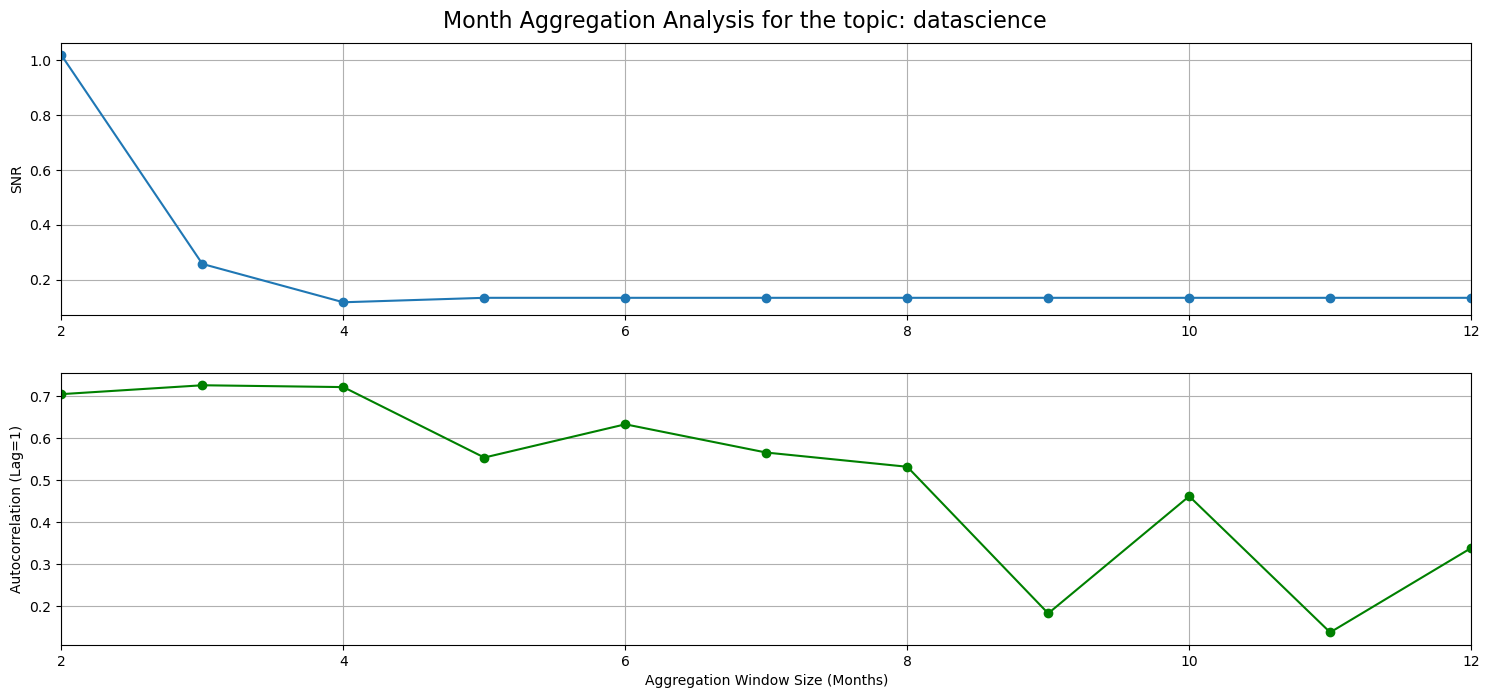

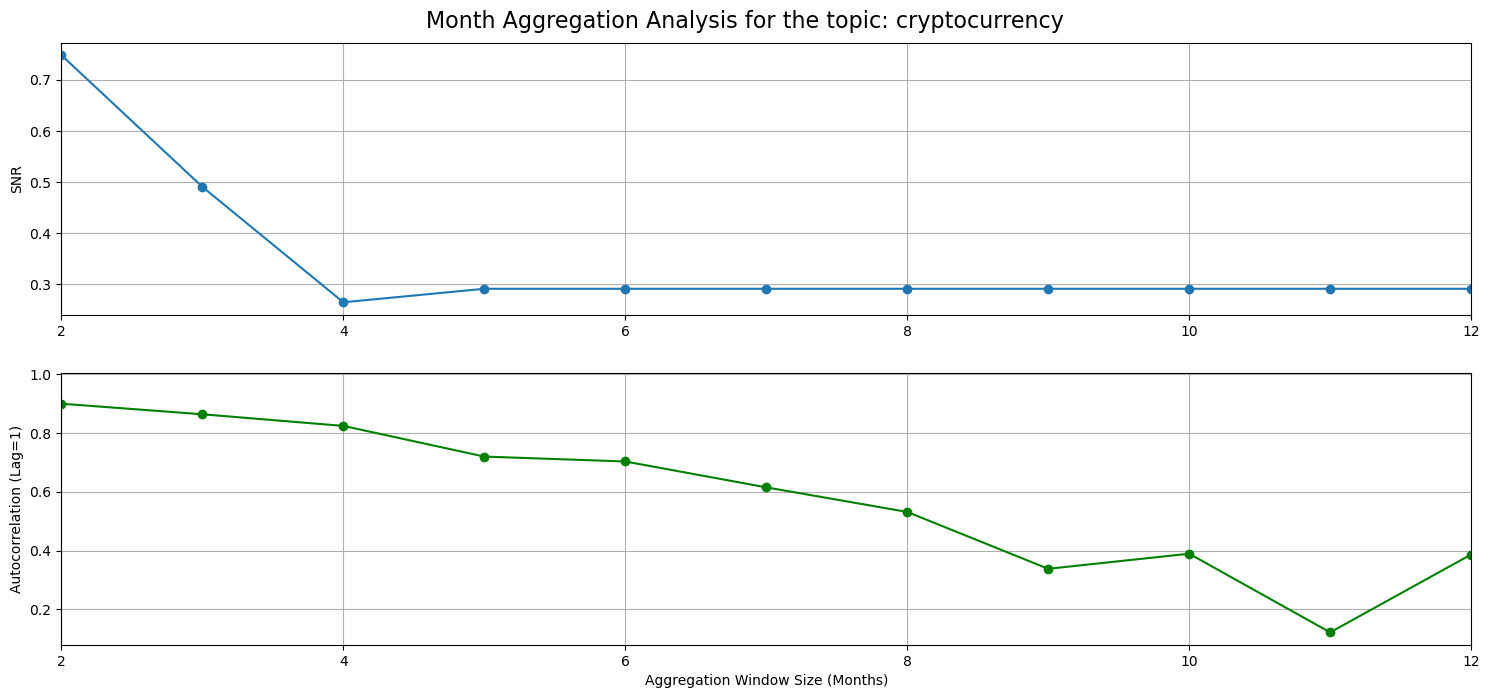

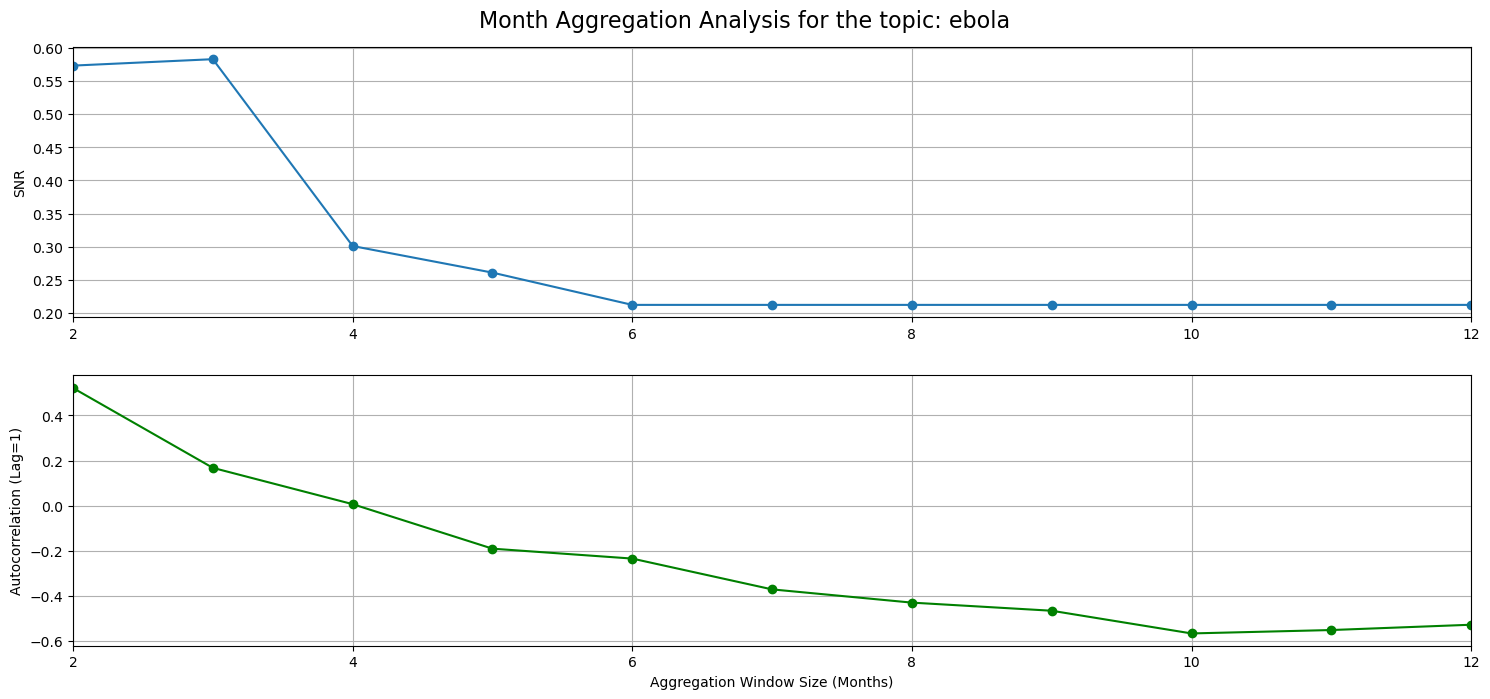

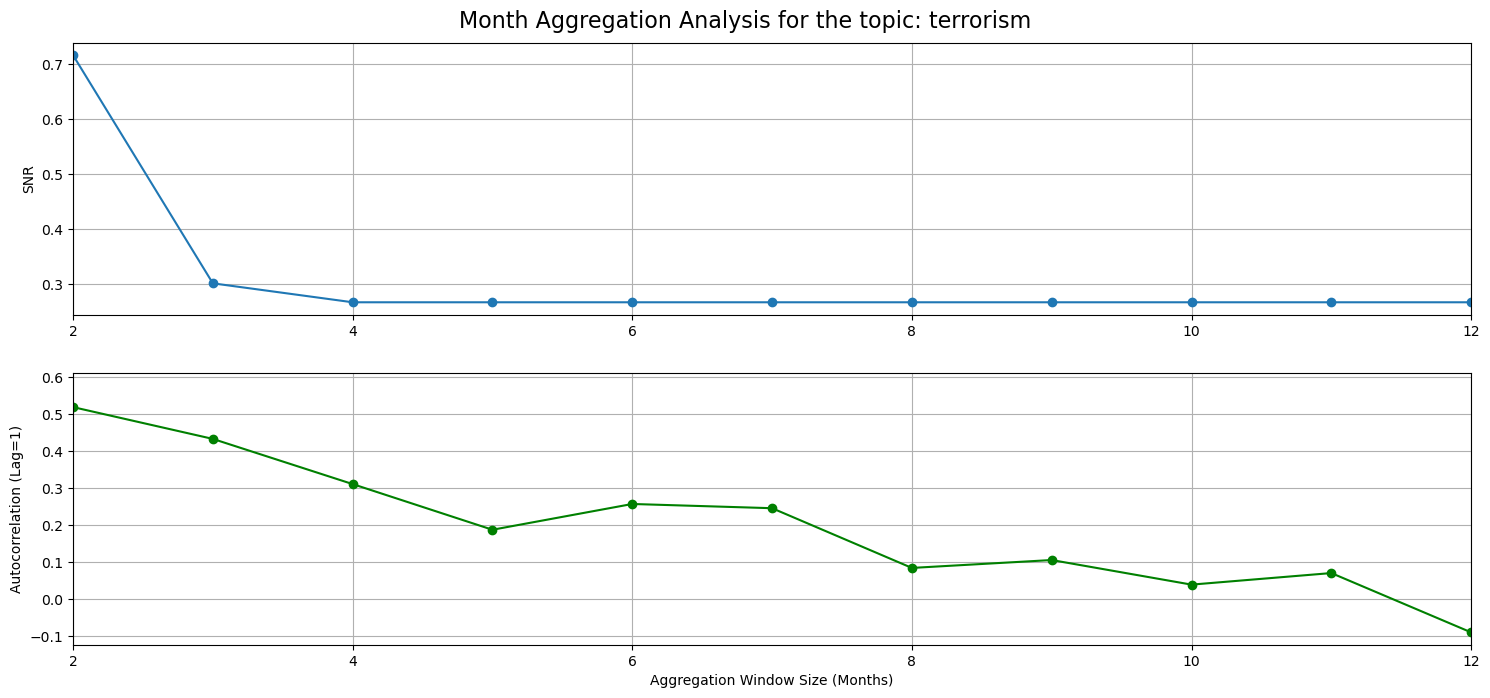

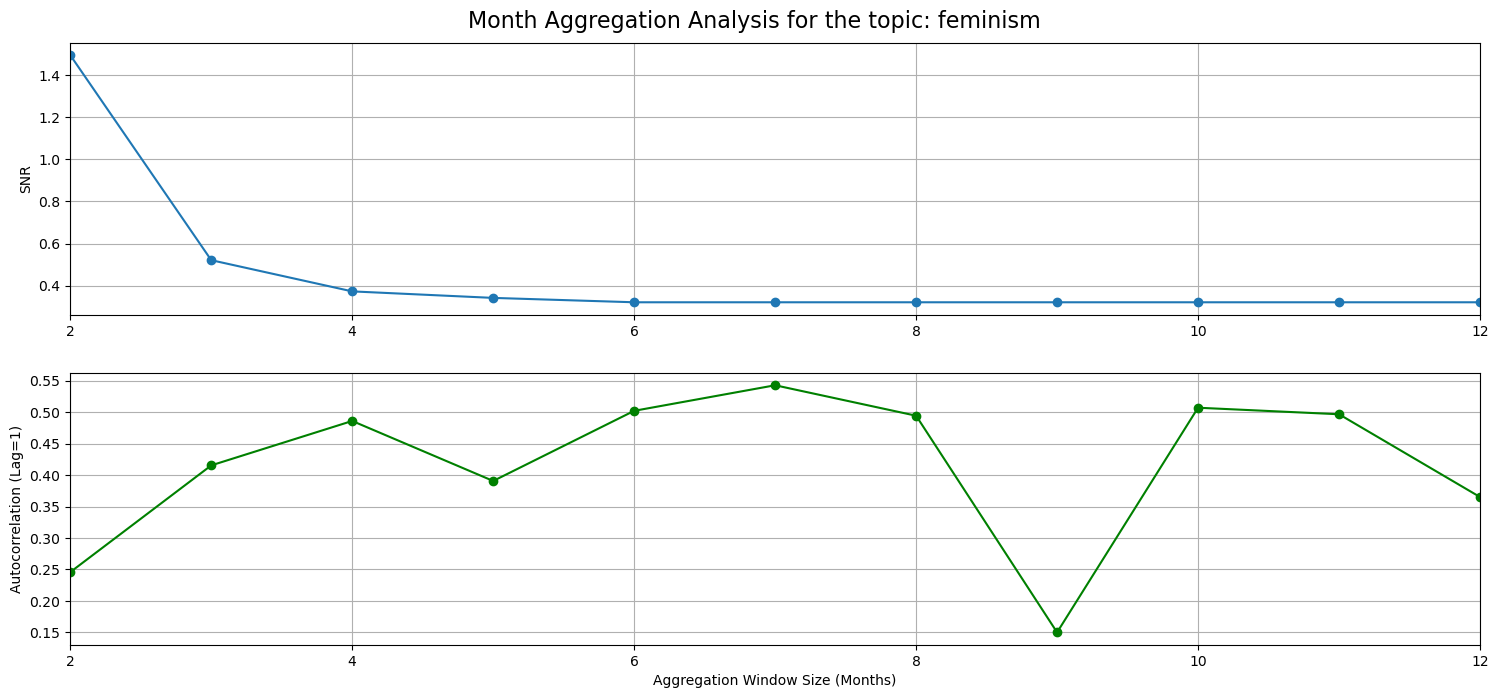

In [266]:
for topic in topics: 
    #metrics = {'SNR': [], 'Explained Variance': [], 'Autocorrelation': []}
    metrics = {'SNR': [], 'Autocorrelation': []}

    window_sizes = range(1, 13)

    time_series_df = pd.read_csv(os.path.join('time_series_df', topic + '_time_series.csv'))
    time_series_df.set_index('categories', inplace=True)
    time_series_df.columns = pd.to_datetime(time_series_df.columns, format='%Y-%m')
    
    for window in window_sizes:
        time_series_transposed = time_series_df.T
        time_series_transposed.index = pd.to_datetime(time_series_transposed.index, format='%Y-%m')
        agg_time_series_transposed = time_series_transposed.resample(f'{window}ME').sum()
        aggregated_sum = agg_time_series_transposed.sum(axis=1)
        agg_time_series_df = agg_time_series_transposed.T
        
        snr = calculate_snr(agg_time_series_df.sum(axis=1), window)
        #explained_variance = calculate_explained_variance_ratio(agg_time_series_df.sum(axis=1), aggregated_sum)
        autocorrelation = calculate_autocorrelation(aggregated_sum, lag=1)
        
        metrics['SNR'].append(snr)
        #metrics['Explained Variance'].append(explained_variance)
        metrics['Autocorrelation'].append(autocorrelation)

    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Month Aggregation Analysis for the topic: {topic}", fontsize=16)

    plt.subplot(3, 1, 1)
    plt.plot(window_sizes, metrics['SNR'], marker='o')
    #plt.title('Signal-to-Noise Ratio vs Aggregation Window')
    #plt.xlabel('Aggregation Window Size (Months)')
    plt.ylabel('SNR')
    plt.xlim((2,12))
    plt.grid()

    """
    plt.subplot(3, 1, 2)
    plt.plot(window_sizes, metrics['Explained Variance'], marker='o', color='orange')
    #plt.title('Explained Variance Ratio vs Aggregation Window')
    #plt.xlabel('Aggregation Window Size (Months)')
    plt.ylabel('Explained Variance Ratio')
    """
    #plt.subplot(3, 1, 3)
    plt.subplot(3, 1, 2)
    plt.plot(window_sizes, metrics['Autocorrelation'], marker='o', color='green')
    #plt.title('Autocorrelation vs Aggregation Window')
    plt.xlabel('Aggregation Window Size (Months)')
    plt.ylabel('Autocorrelation (Lag=1)')
    plt.xlim((2,12))
    plt.grid()

    plt.tight_layout()
    plt.show()


/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/3446576992.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()


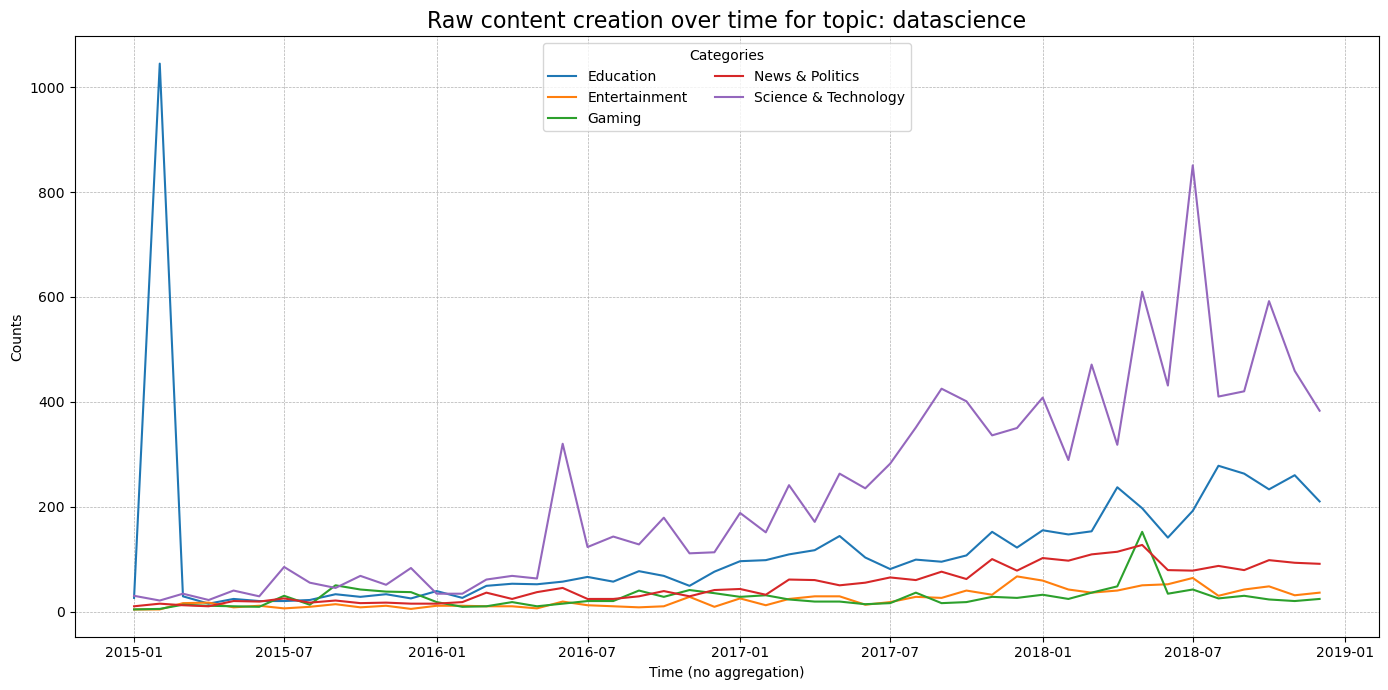

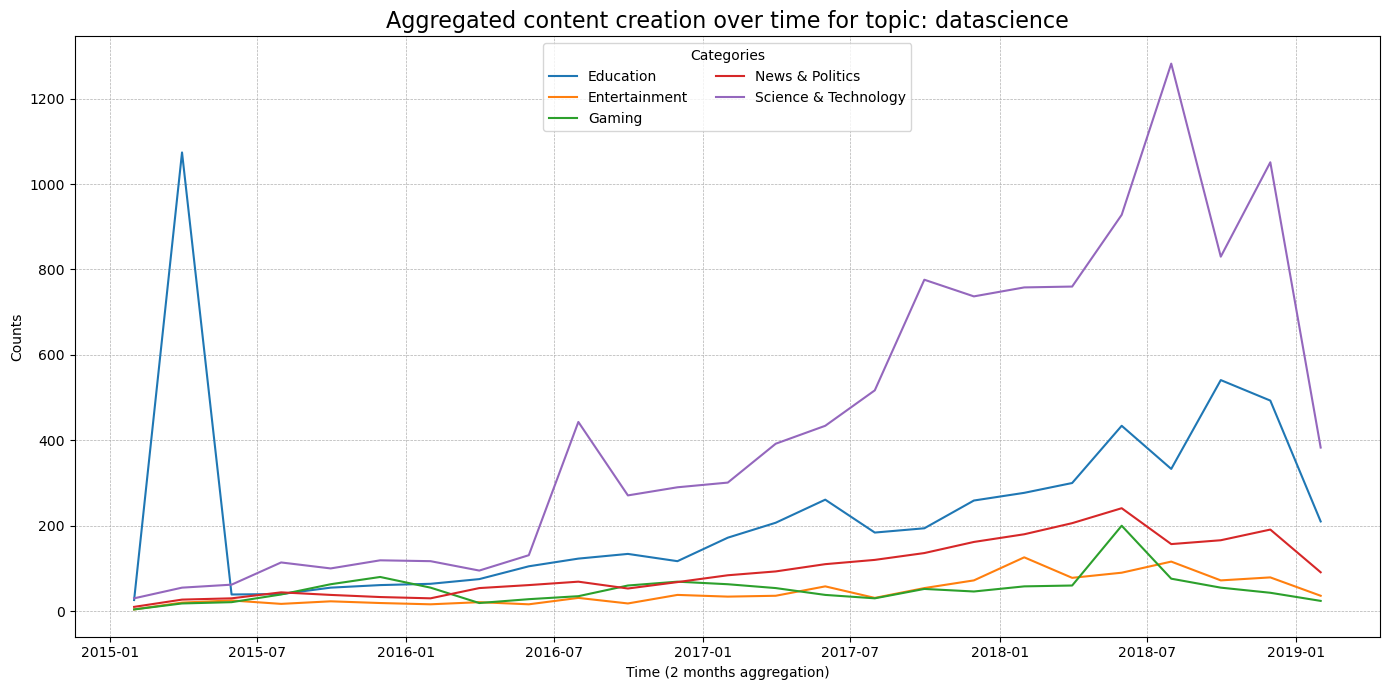

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/3446576992.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()


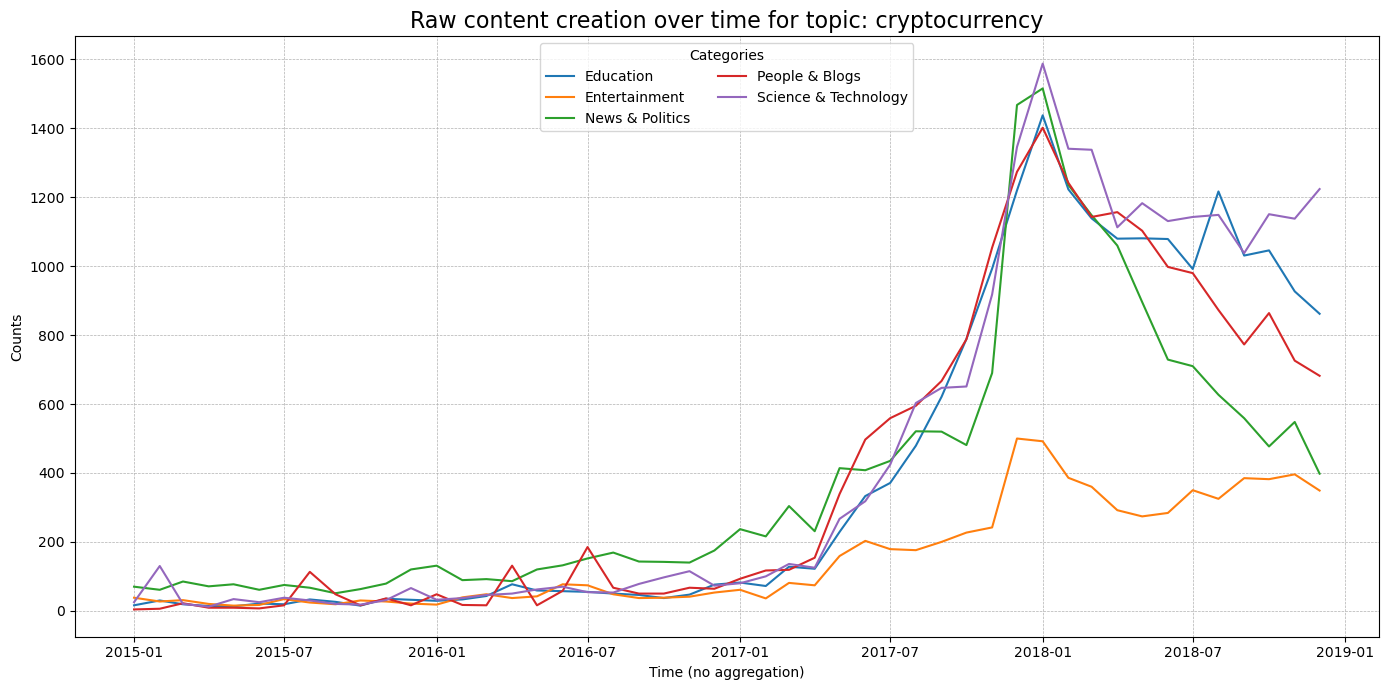

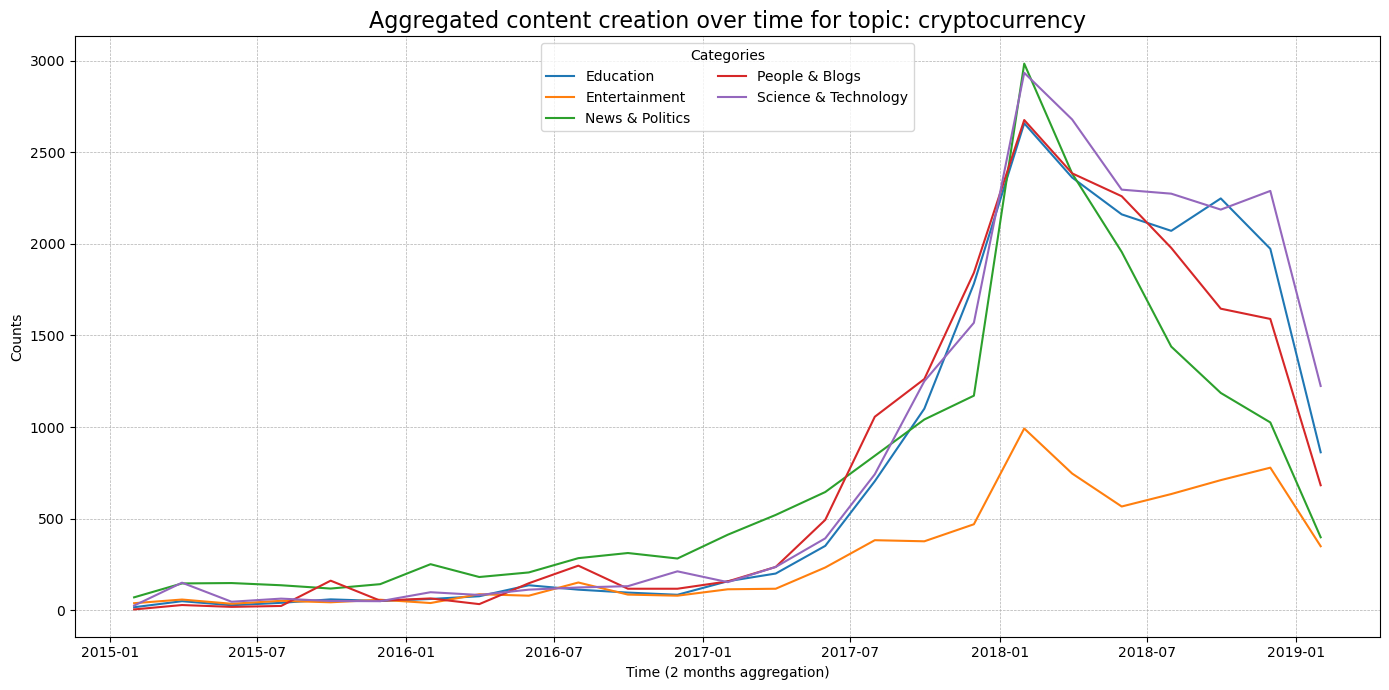

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/3446576992.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()


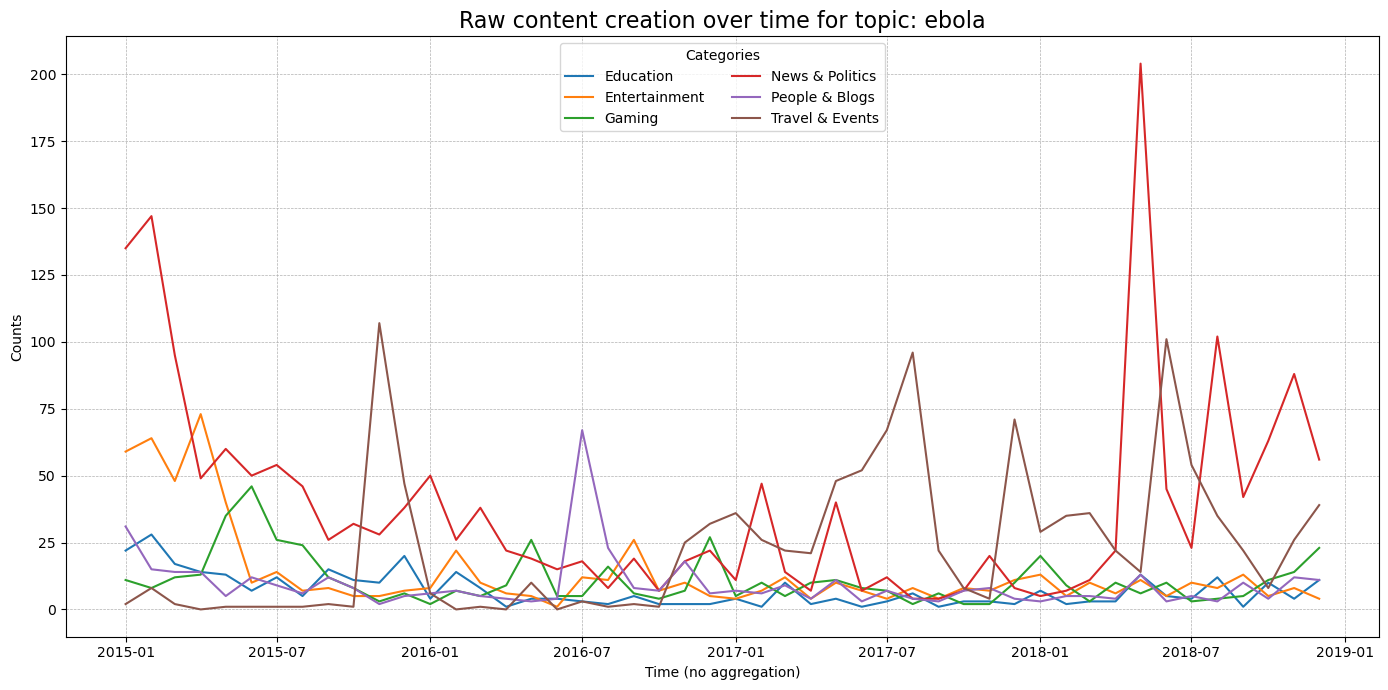

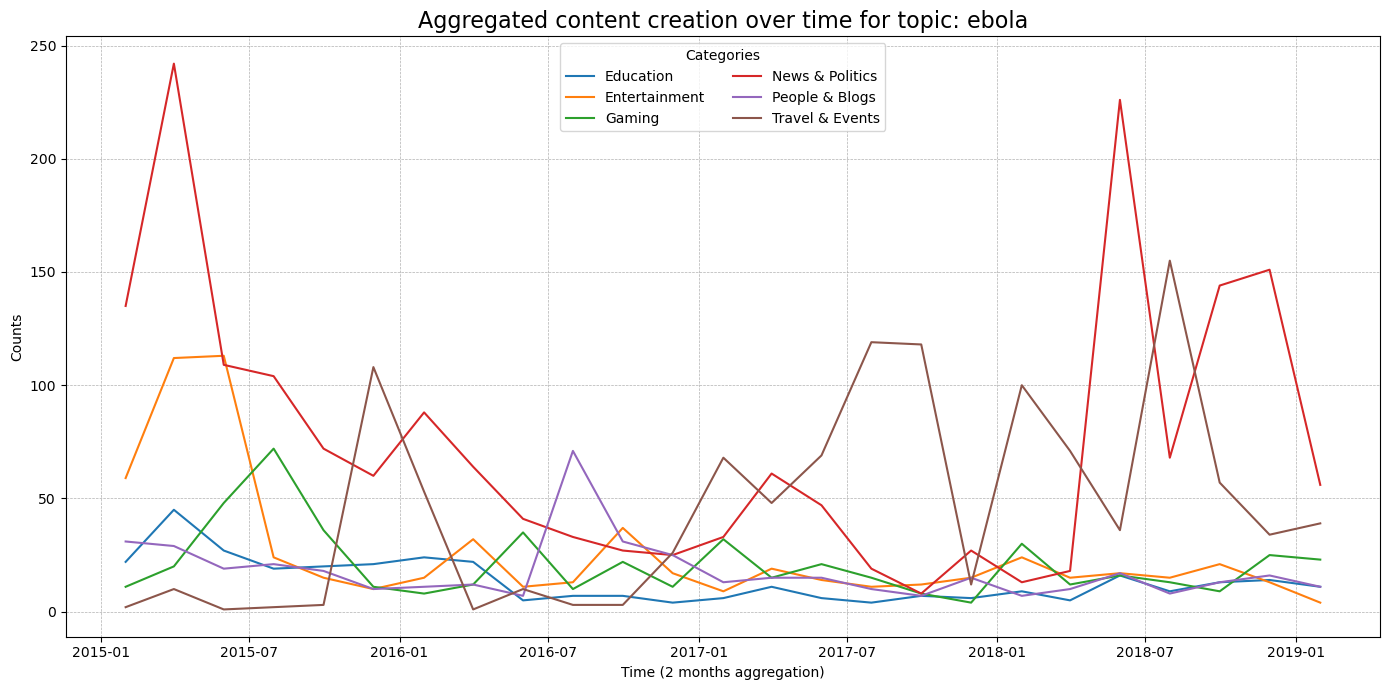

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/3446576992.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()


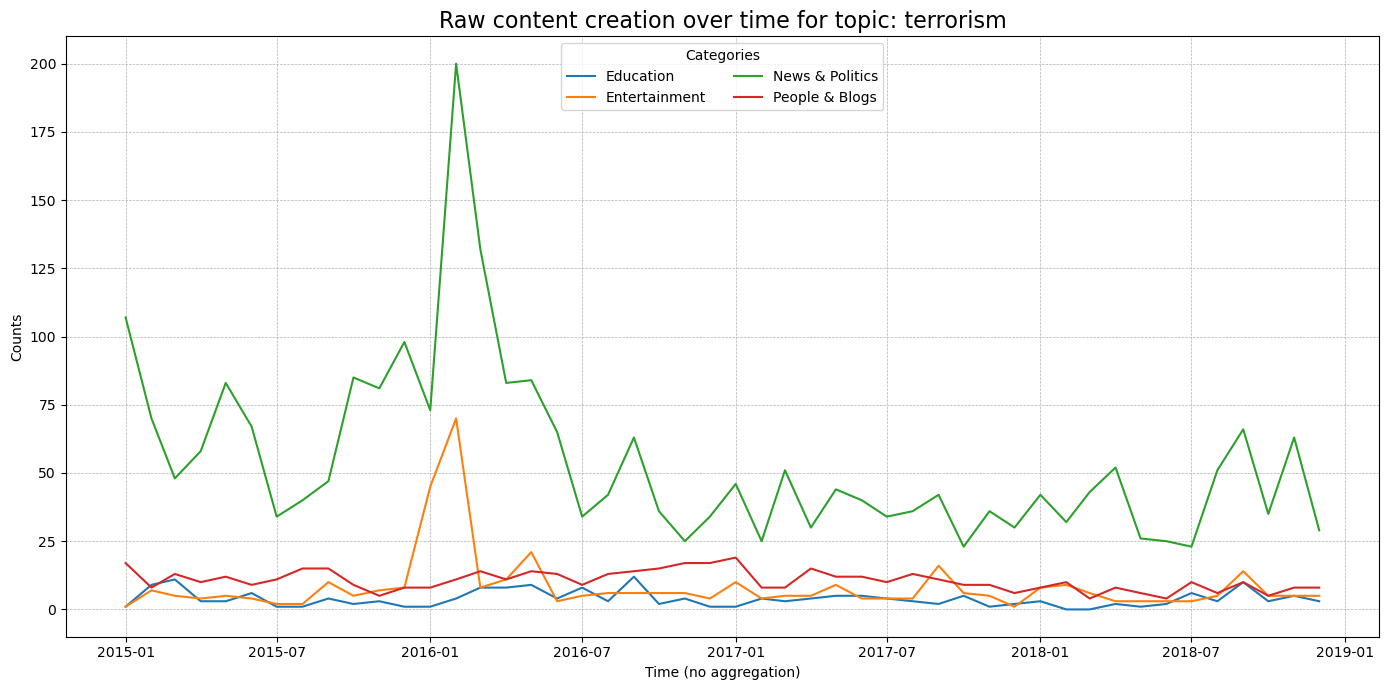

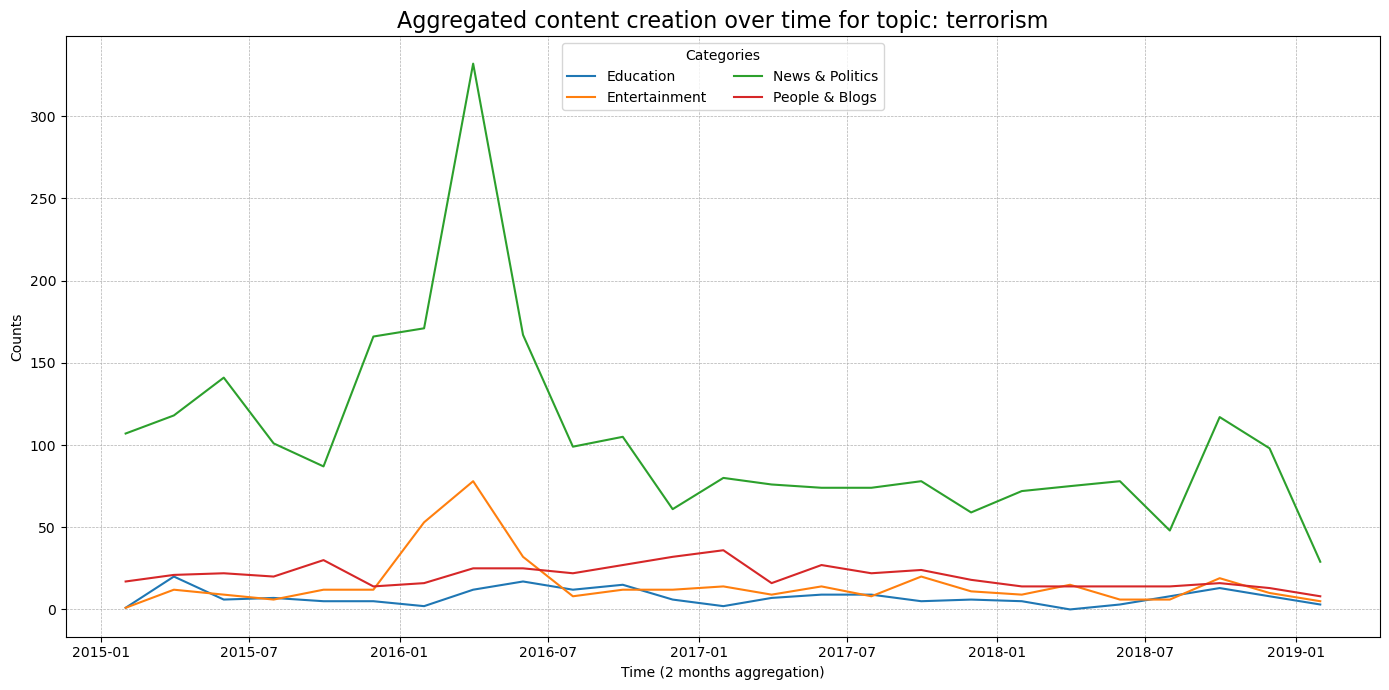

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/3446576992.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()


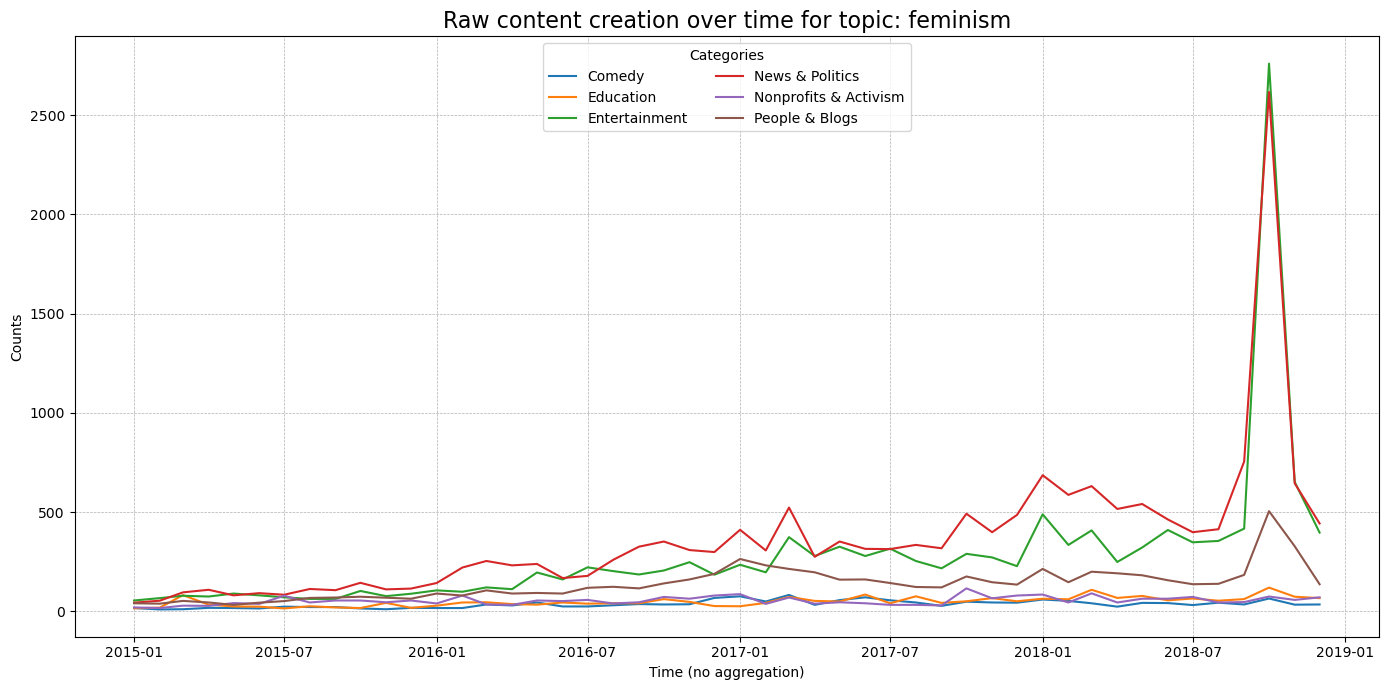

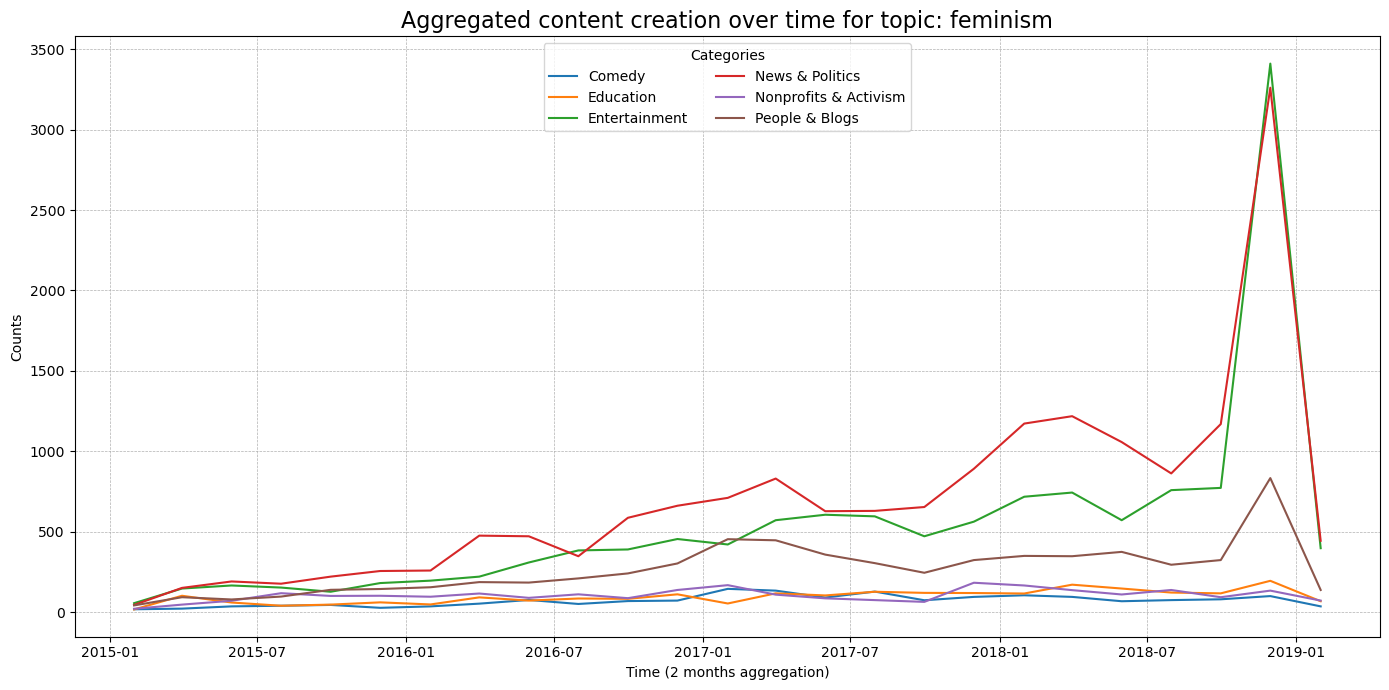

In [149]:
# Plotting aggregated time series based on the time window previously selected 

for topic in topics:
    time_series_df = pd.read_csv(os.path.join('time_series_df', topic + '_time_series.csv'))
    time_series_df.set_index('categories', inplace=True)
    time_series_df.columns = pd.to_datetime(time_series_df.columns, format='%Y-%m')
    time_series_transposed = time_series_df.T
    time_series_transposed.index = pd.to_datetime(time_series_transposed.index, format='%Y-%m')
    agg_time_series_transposed = time_series_transposed.resample('2M').sum()
    agg_time_series_df = agg_time_series_transposed.T
    #print(time_series_df)
    plt.figure(figsize=(14, 7))

    for category in time_series_df.index:
        plt.plot(time_series_df.columns, time_series_df.loc[category], label=category)

    plt.title(f"Raw content creation over time for topic: {topic}", fontsize=16)
    plt.grid(axis='both', which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper center', title="Categories", ncol=2)
    plt.xlabel("Time (no aggregation)")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))

    for category in agg_time_series_df.index:
        plt.plot(agg_time_series_df.columns, agg_time_series_df.loc[category], label=category)

    plt.title(f"Aggregated content creation over time for topic: {topic}", fontsize=16)
    plt.grid(axis='both', which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper center', title="Categories", ncol=2)
    plt.xlabel("Time (2 months aggregation)")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()

# 4. ANALYSIS
## 4.1. Dynamic Time Warping (DTW): Measure similarity between two time series

In [267]:
def rolling_dtw_analysis(time_series_df, target_series_name='Education', window_size=3, save_path=None):
    """
    Perform rolling DTW analysis between a target series and all other series in a DataFrame.

    Parameters:
    - time_series_df (pd.DataFrame): DataFrame with time series data, rows as series and columns as time points.
    - target_series_name (str): The name of the target series to compare against.
    - window_size (int): Window size for rolling DTW computation.
    - save_path (str, optional): Path to save the plot. If None, the plot is displayed but not saved.

    Returns:
    - rolling_dtw_results (dict): Dictionary with categories as keys and their DTW distances as values.
    - plt.Figure: A plot showing DTW distances over time.
    """
    def rolling_dtw(series, target_series, window_size):
        dtw_distances = []
        for i in range(len(series) - window_size + 1):
            segment = series[i:i + window_size]
            target_segment = target_series[i:i + window_size]
            distance = euclidean(segment, target_segment)
            dtw_distances.append(distance)
        return dtw_distances

    Normaize = True
    if Normaize:
        scaler = StandardScaler()
        normalized_df = pd.DataFrame(
            
            scaler.fit_transform(time_series_df.values.T),
            index=time_series_df.columns,
            columns=time_series_df.index
        )
        normalized_df = normalized_df.T
    else: 
        normalized_df = time_series_df
        
    target_series = normalized_df.loc[target_series_name].values

    rolling_dtw_results = {}

    for category in time_series_df.index:
        if category != target_series_name:
            series = normalized_df.loc[category].values
            rolling_dtw_result = rolling_dtw(series, target_series, window_size=window_size)
            #time_index = [pd.Timestamp(col).strftime('%Y-%m') for col in normalized_df.columns[:len(series) - window_size + 1]]
            time_index = ['06-2015', '08-2015', '10-2015', '12-2015', 
                '02-2016', '04-2016', '06-2016', '08-2016',
                '10-2016', '12-2016', '02-2017', '04-2017',
                '06-2017', '08-2017', '10-2017', '12-2017',
                '02-2018', '04-2018', '06-2018', '08-2018']
            rolling_dtw_results[category] = pd.Series(rolling_dtw_result, index=time_index)

    plt.figure(figsize=(14, 7))
    
    from cycler import cycler

    colors = plt.cm.tab10.colors[1:]
    plt.gca().set_prop_cycle(cycler(color=colors))

    for category, dtw_series in rolling_dtw_results.items():
        plt.plot(dtw_series, label=category)

    plt.xlabel('Time (looking at {} period time)'.format(window_size))
    plt.ylabel('Normalized DTW Distance')
    plt.title(f'Dynamic Time Warping of {target_series_name} with other categories for topic: {topic}')
    plt.legend(loc='upper left')
    plt.grid(axis='y')
    plt.tight_layout()

    if not os.path.exists('analysis'):
        os.makedirs('analysis')
    plt.savefig(os.path.join('analysis',save_path))

    return rolling_dtw_results

## 4.2. Granger Causality Test: Determine if one time series can forecast another

In [ ]:
def granger_causality_analysis(time_series_df, target_series_name='Education', max_lag=12, save_path=None):
    def granger_causality_test(series, target_series, max_lag):
        series_df = pd.DataFrame({
            'target_series': target_series.values,
            'cause_series': series.values
        })
        test_result = grangercausalitytests(series_df[['target_series', 'cause_series']], maxlag=max_lag, verbose=False)
        p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
        return p_values

    target_series = time_series_df.loc[target_series_name]

    granger_results = {}

    for category in time_series_df.index:
        if category != target_series_name:
            category_series = time_series_df.loc[category]
            p_values = granger_causality_test(category_series, target_series, max_lag=max_lag)
            granger_results[category] = p_values

    results_df = pd.DataFrame.from_dict(granger_results, orient='index', columns=[f'Lag {i+1}' for i in range(max_lag)])

    plt.figure(figsize=(8, 6))
    sns.heatmap(results_df, annot=True, fmt='.4f', cmap='coolwarm', cbar_kws={'label': 'p-value'})
    plt.title(f'Granger Causality Results for {target_series_name}')
    plt.xlabel('Lags')
    plt.ylabel('Categories')

    if save_path:
        if not os.path.exists('analysis'):
            os.makedirs('analysis')
        plt.savefig(os.path.join('analysis', save_path))

    plt.show()

    return granger_results

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/2416354249.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functio

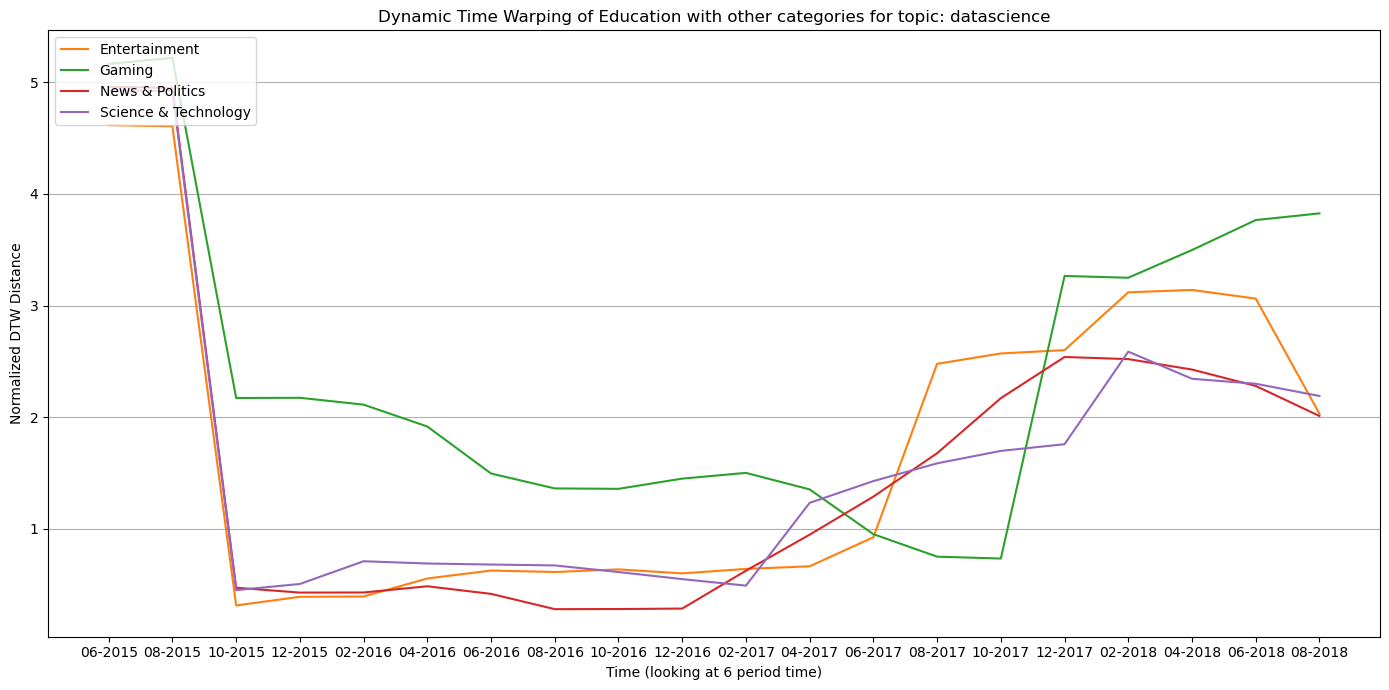

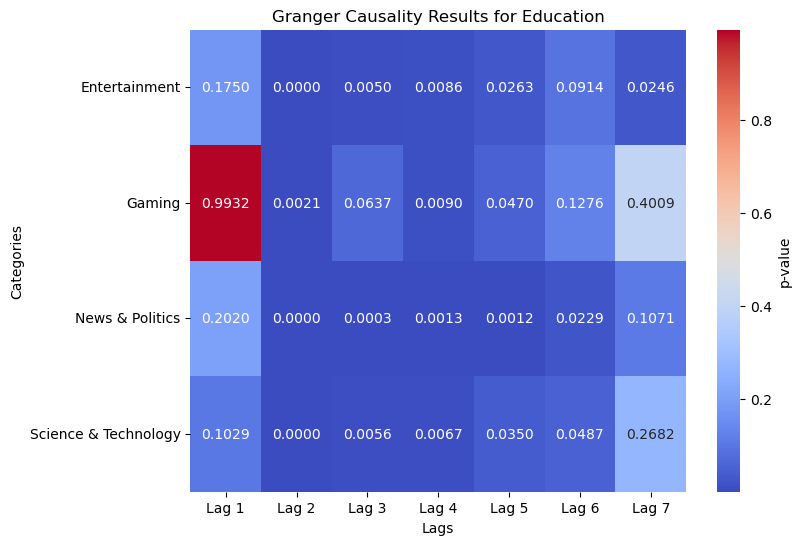

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/2416354249.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functio

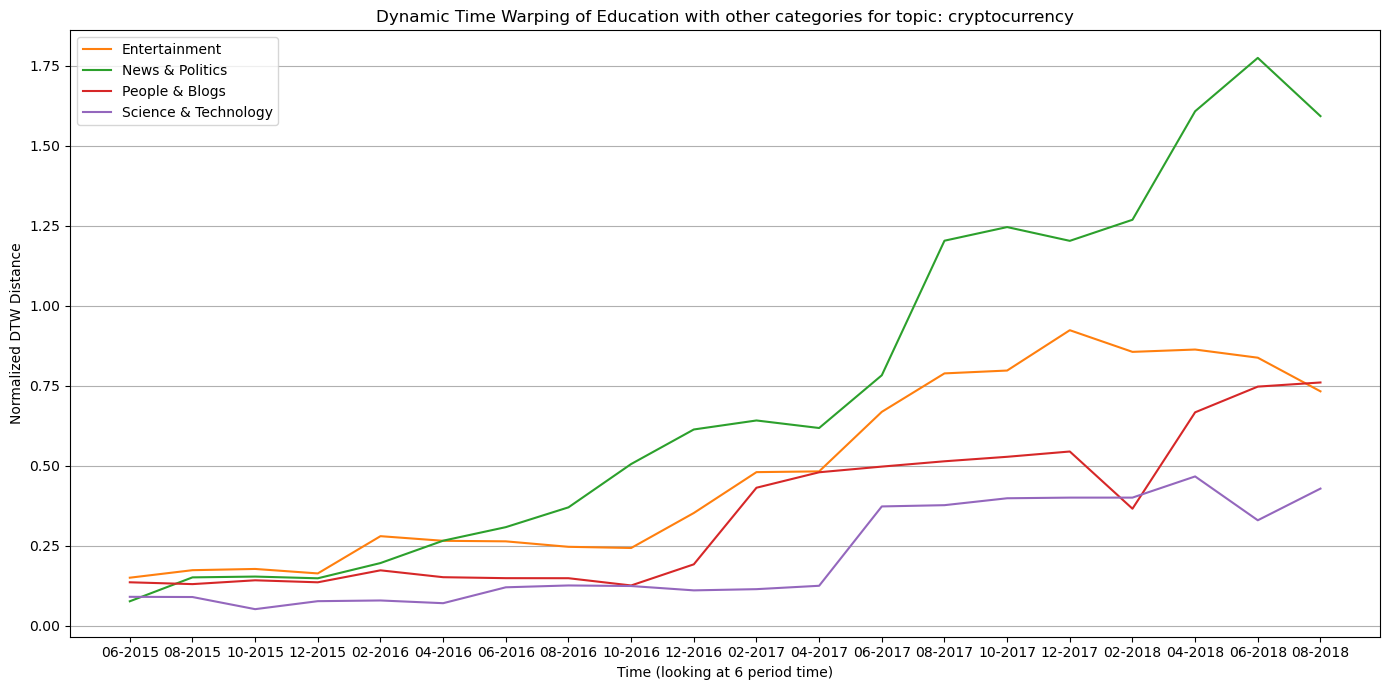

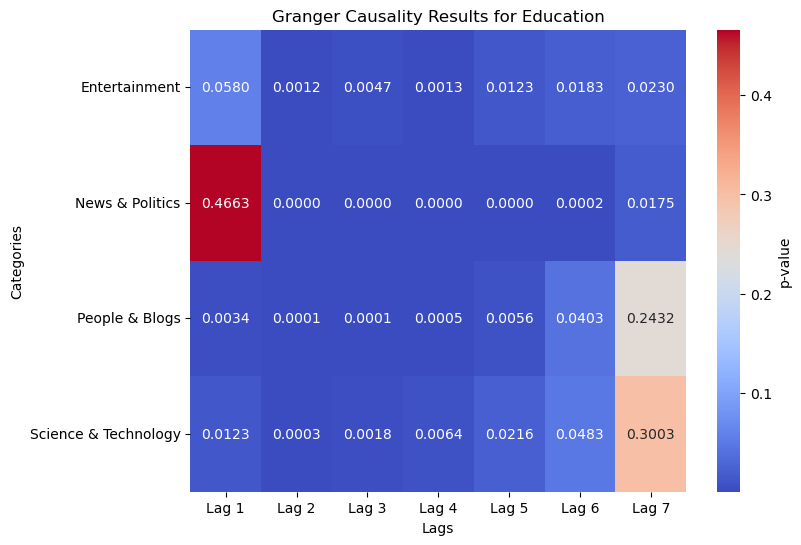

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/2416354249.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functio

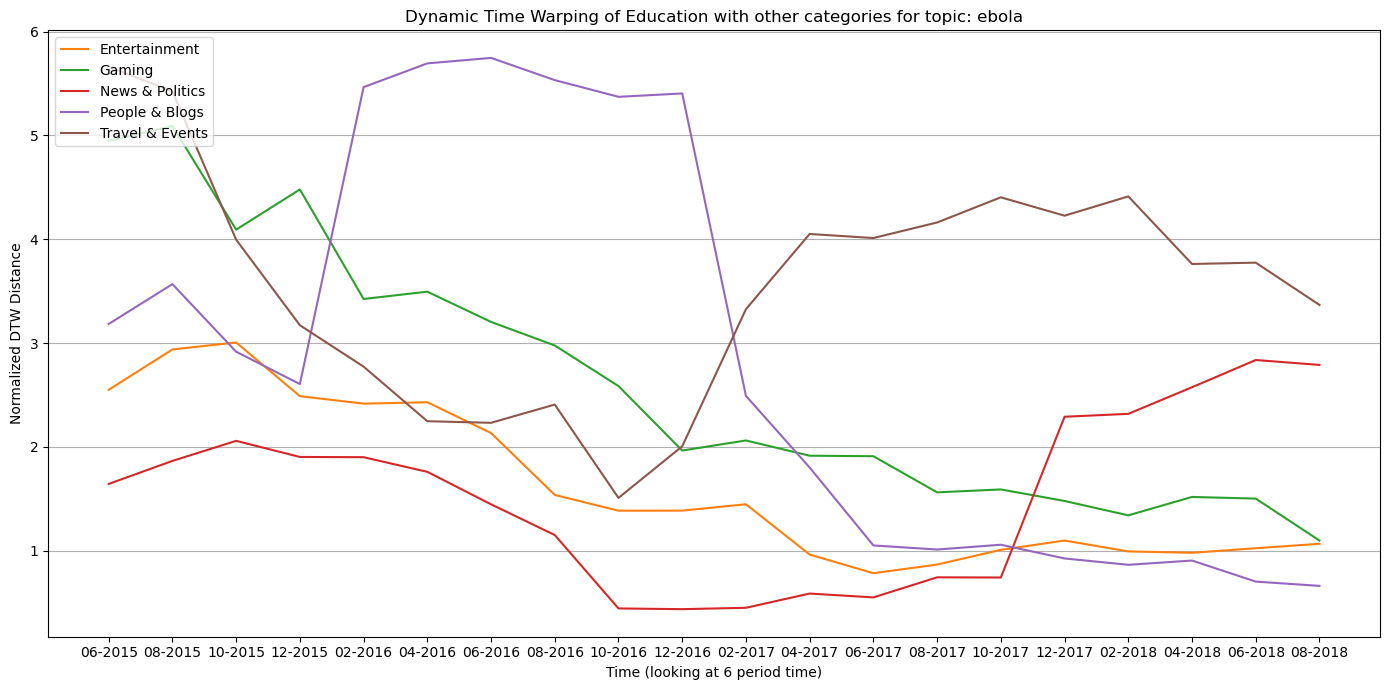

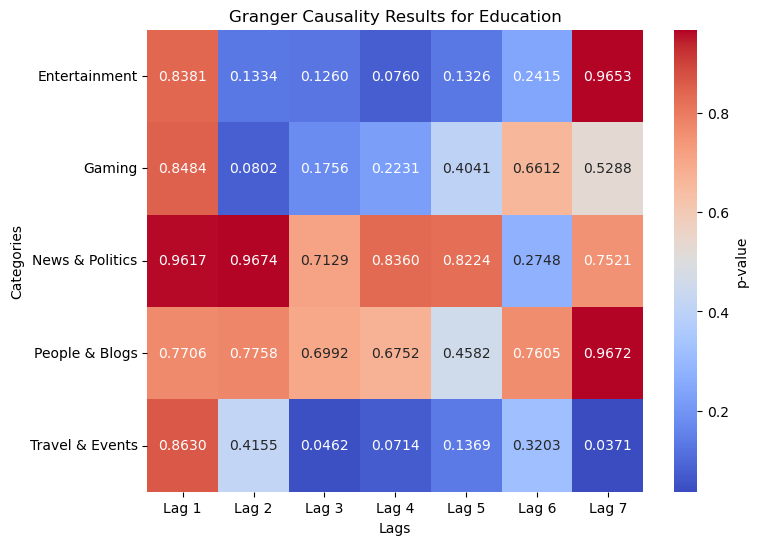

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/2416354249.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


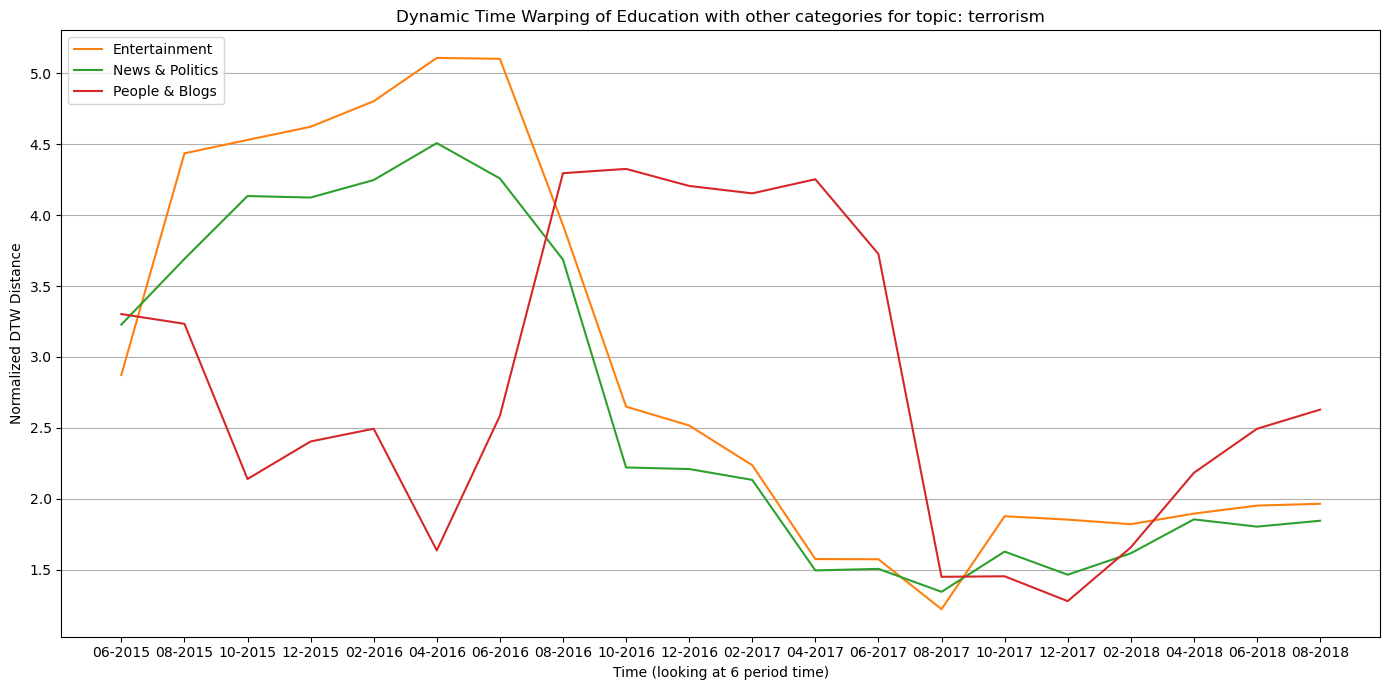

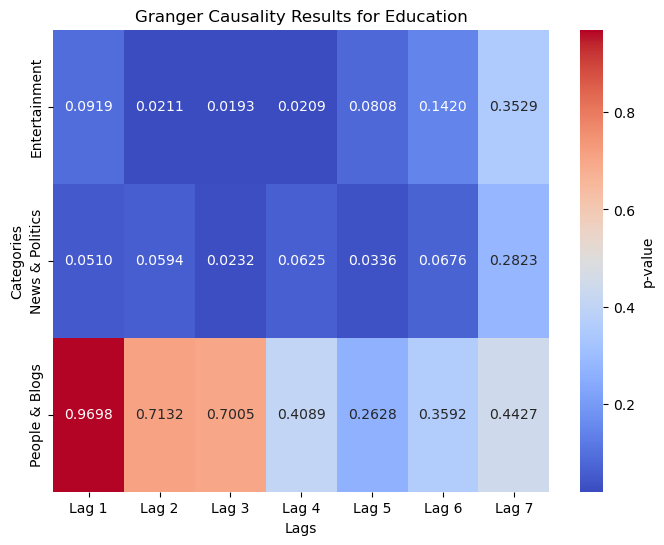

/var/folders/1y/f431dfd55sgcrd9ymcz950th0000gn/T/ipykernel_12563/2416354249.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg_time_series_transposed = time_series_transposed.resample('2M').sum()
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/yanndevance/anaconda3/envs/ada/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functio

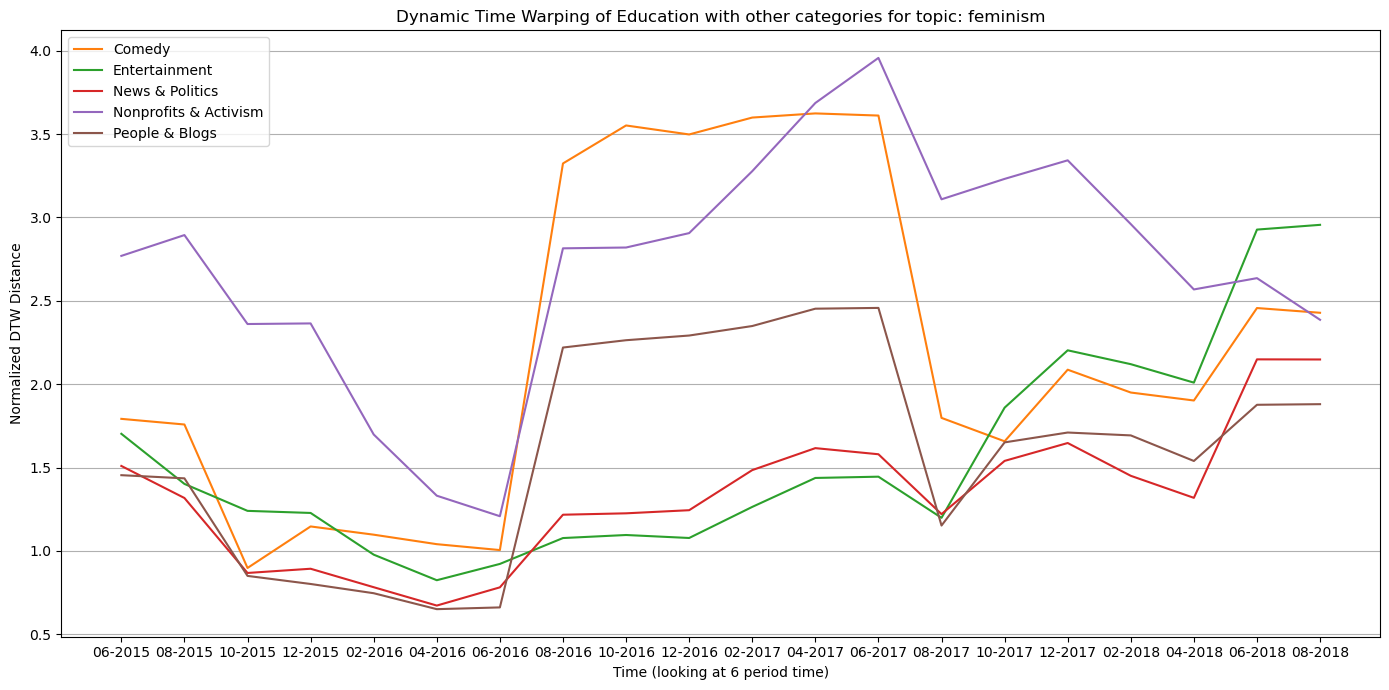

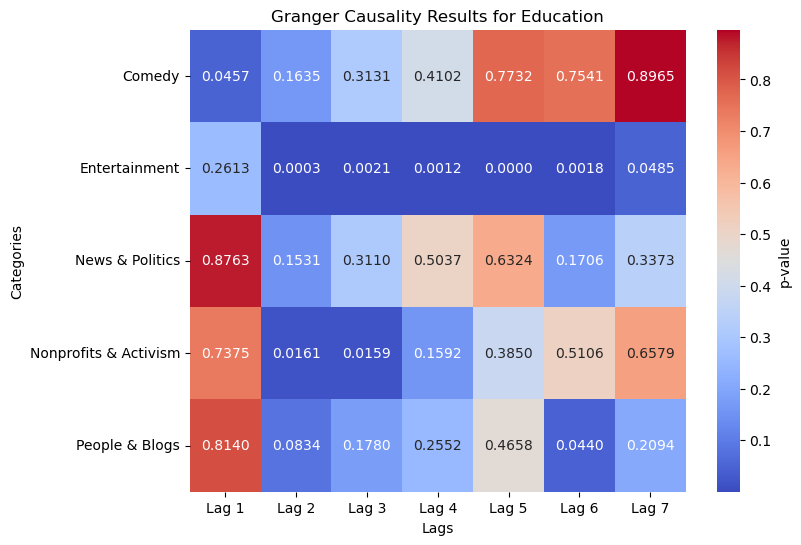

In [ ]:
# Pipeline execution

for topic in topics:
    time_series_df = pd.read_csv(os.path.join('time_series_df', topic + '_time_series.csv'))
    time_series_df.set_index('categories', inplace=True)

    time_series_df.columns = pd.to_datetime(time_series_df.columns, format='%Y-%m')
    time_series_transposed = time_series_df.T
    time_series_transposed.index = pd.to_datetime(time_series_transposed.index, format='%Y-%m')
    agg_time_series_transposed = time_series_transposed.resample('2M').sum()
    agg_time_series_df = agg_time_series_transposed.T
    rolling_dtw_results = rolling_dtw_analysis(agg_time_series_df, target_series_name='Education', window_size=6, save_path= topic + '_rolling_dtw')
    granger_results = granger_causality_analysis(agg_time_series_df, target_series_name='Education', max_lag=7, save_path= topic + '_granger')

## COMMENTS: EVENT-BASED ANALYSIS

### Datascience:

- November 2015: Google open-sourced TensorFlow, its machine learning framework, significantly advancing AI and machine learning research and applications.
- February 2017: The release of TensorFlow 1.0.0 marked a milestone in machine learning development.
- February 2019: OpenAI introduced GPT-2, a large-scale unsupervised language model, showcasing advancements in natural language processing.

### Cryptocurrency:

- December 2017: Bitcoin's price surged to nearly $20,000, attracting significant public and media attention.
- January 2018: The cryptocurrency market experienced a substantial decline, with Bitcoin's value dropping by approximately 65% from its peak, leading to discussions about market volatility.
- June 2019: Facebook announced plans for Libra, a digital currency, sparking global regulatory discussions and debates about the future of digital currencies.

### Ebola:

- August 2014 – March 2016: The West African Ebola outbreak led to widespread health crises and international response efforts.
- August 2018: A new Ebola outbreak was declared in the Democratic Republic of Congo, prompting renewed global health concerns and interventions.

### Terrorism:

- November 2015: The Paris attacks, orchestrated by ISIS, resulted in 130 deaths, influencing global counter-terrorism policies and public sentiment.
- May 2017: The Manchester Arena bombing during an Ariana Grande concert killed 22 people, highlighting ongoing threats from extremist groups.
- April 2019: The Easter Sunday bombings in Sri Lanka targeted churches and hotels, causing over 250 deaths and raising concerns about global terrorism.

### Feminism:

- October 2017: The #MeToo movement gained global prominence, with numerous individuals sharing experiences of sexual harassment and assault, leading to widespread discussions on gender equality.
- January 2018: The Women's Marches continued worldwide, advocating for women's rights, gender equality, and other social issues, reflecting the growing momentum of feminist movements.

# BEGINNING OF THE WEBPAGE

### Introduction

"Who is controlling the information?" To answer this question, we aim to explore the influence of content creation across various categories on YouTube over time. By examining how different topics shape and interact with content in diverse categories, we aim to uncover the underlying dynamics of information dissemination on the platform.

In this section, we focus on one of these topics: Data Science. This study utilizes a comprehensive pipeline developed in the `spread.ipynb` notebook, designed to extract videos from the original YouNiverse dataset. The dataset is not limited to educational content, but spans a broad range of categories including Autos & Vehicles, Comedy, Education, Entertainment, Film & Animation, Gaming, How-to & Style, Music, News & Politics, Nonprofits & Activism, People & Blogs, Pets & Animals, Science & Technology, Sports, and Travel & Events. These categories are determined based on the information provided by the YouTuber who uploaded the video, with the assumption that this classification is accurate.

The extraction process focuses on specific keywords within video titles and tags to ensure exclusivity and relevance. In this case, keywords such as machine learning, deep learning, and artificial intelligence are used to guide the extraction of videos related to Data Science.

Following extraction, subsequent preprocessing steps produce a pandas DataFrame containing monthly time series data, reflecting the number of videos created within these selected categories. Given the vast amount of data available, the analysis focuses on the top categories that collectively account for the majority (typically 90%) of the dataset. This approach ensures that resulting visualizations and analyses remain comprehensible, limited to scalable categories, and based on sufficient data to support meaningful causal investigations.

The study period spans from 2015 to 2018, chosen due to the relatively low volume of data prior to 2015 and the exclusion of the final month of 2019 to avoid seasonality effects that could lead to misleading results.

To refine the analysis, metrics such as the noise-to-signal ratio (SNR), explained variance ratios, and autocorrelation at lag one are employed. These metrics help determine the optimal time window for capturing meaningful insights.

Finally, analytical methods such as Dynamic Time Warping (DTW) and Granger causality are applied to examine the influence of content creation in Education on other categories over time, uncovering the complex interrelationships that shape information flow on YouTube.

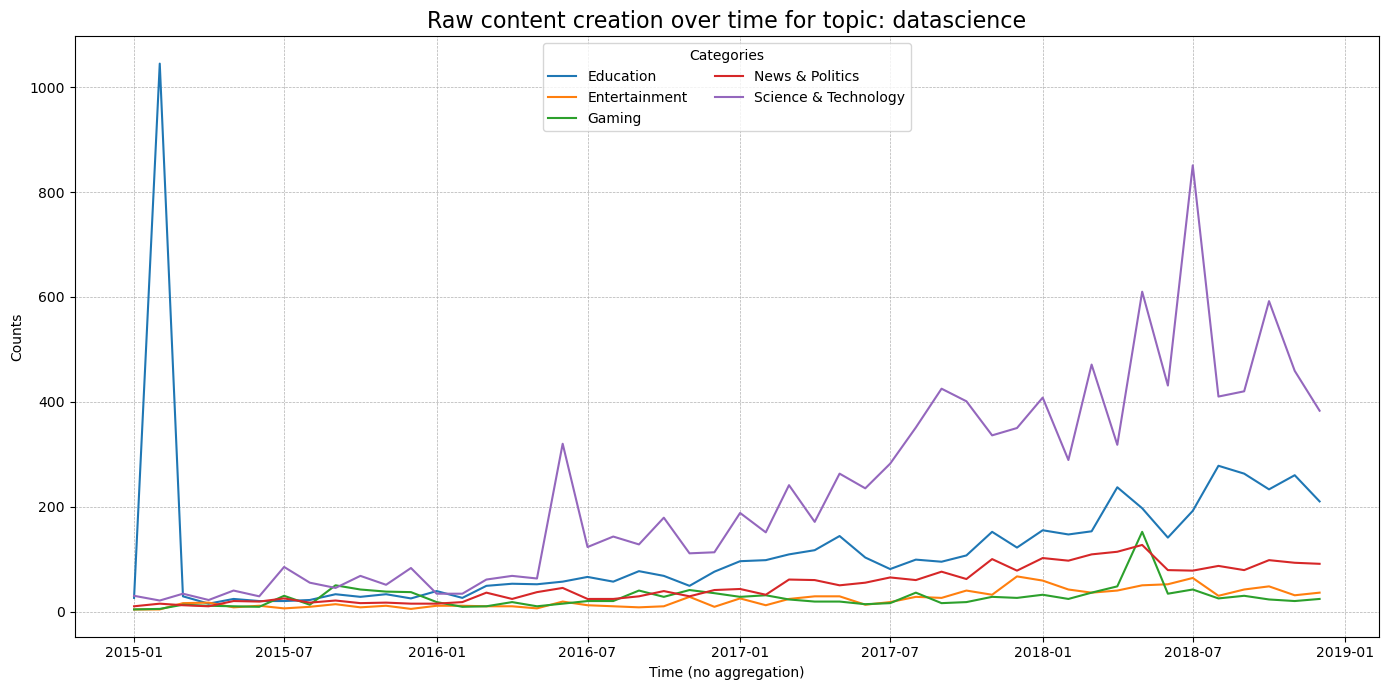

Figure 1: content creation for the top categories related to the topic Data Science over time on a monthly aggregation basis.

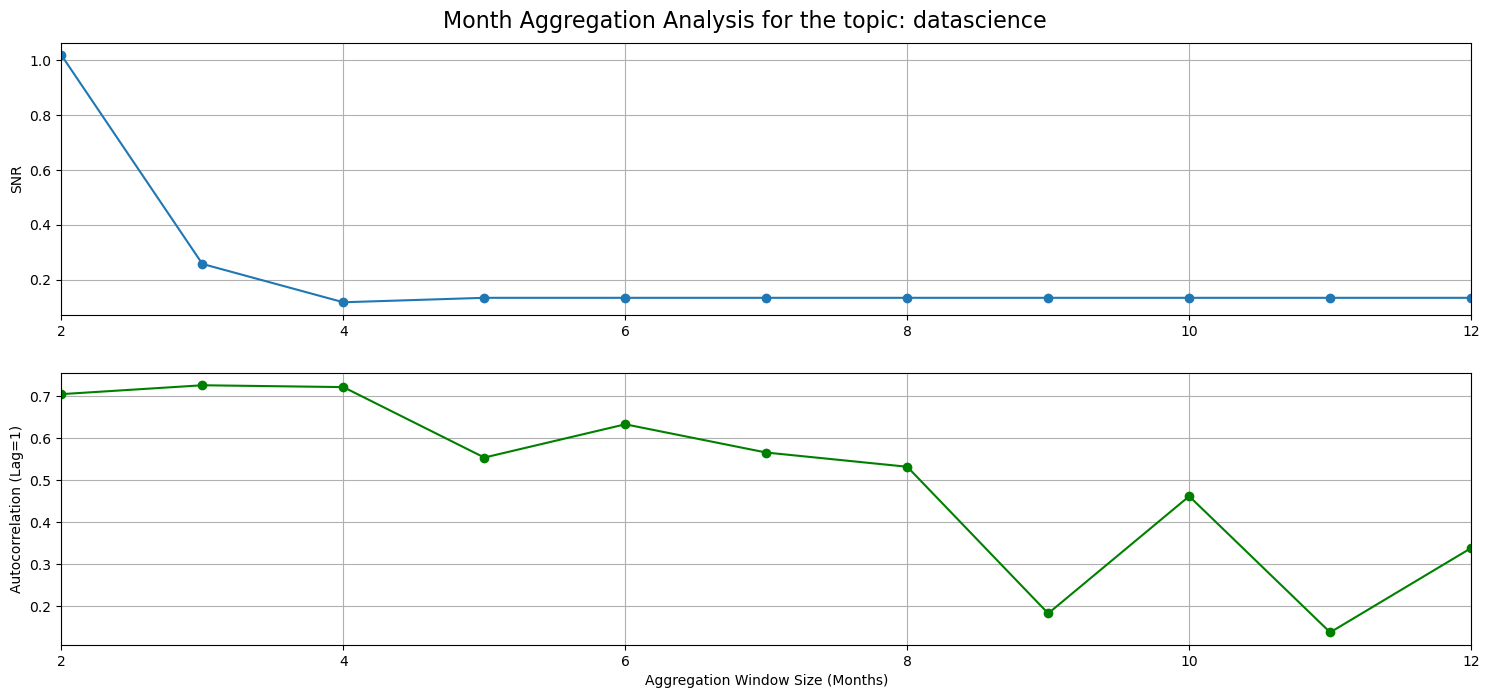

Figure 2: SNR and Autocorrelation at lag 1 for topic Data science.

The Signal-to-Noise Ratio (SNR) and autocorrelation at lag 1 are critical metrics for determining the optimal level of time aggregation in the analysis of time series data. SNR evaluates the proportion of meaningful signal to random noise in the data, with higher values indicating that the aggregation effectively enhances the clarity of underlying trends by reducing noise. Autocorrelation at lag 1 measures the relationship between a data point and its immediate predecessor, capturing the smoothness and temporal consistency of the series. Moderately high autocorrelation values, typically in the range of 0.4 to 0.7, suggest that the series retains enough of its signal while avoiding over-smoothing, which can obscure meaningful short-term variations.

In selecting the best aggregation window, I will balance these two metrics. A high SNR indicates that the aggregation effectively filters noise, while an optimal range of autocorrelation ensures the preservation of temporal structure without excessive smoothing. By plotting these metrics across various aggregation levels, I will identify the window size where SNR is maximized and autocorrelation falls within the target range, ensuring the aggregated data captures both the long-term dynamics and relevant fluctuations of the series. 

We chose 2 month aggregation level.

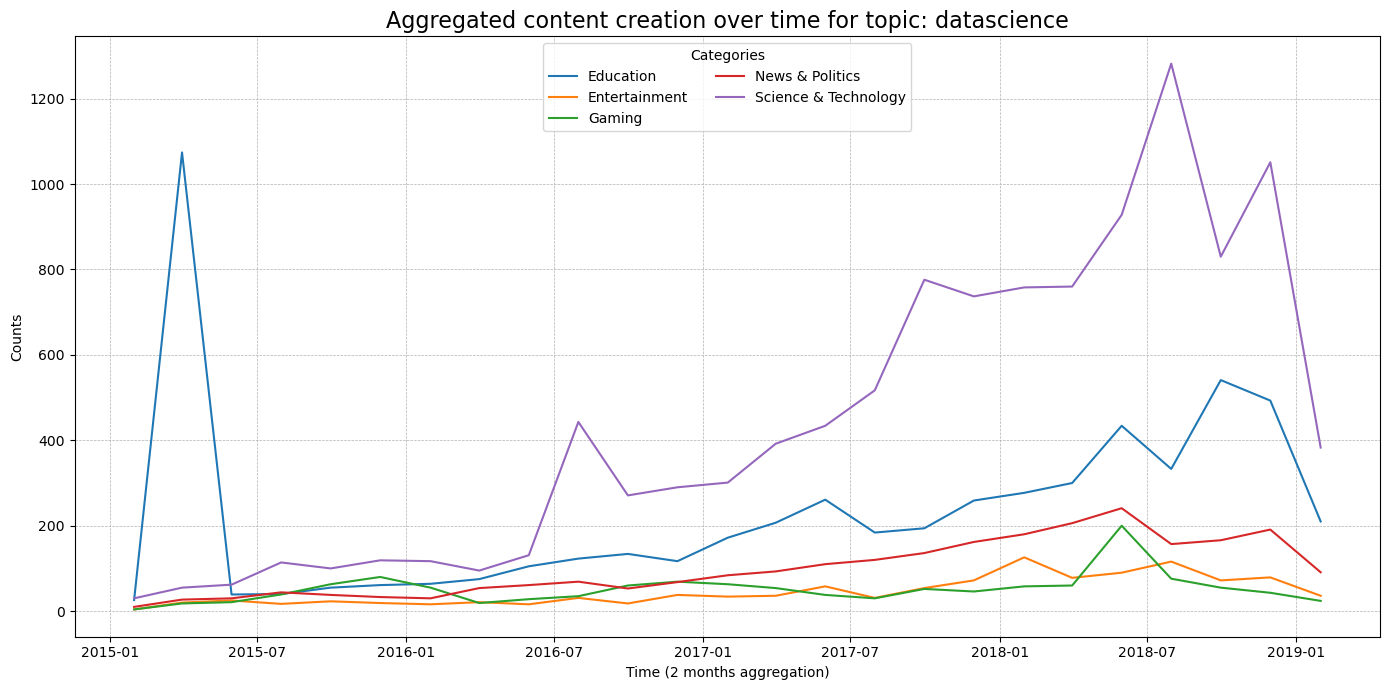

Figure 3: content creation for the top categories related to the topic Data Science over time on a two month aggregation basis.

Let's see where these events fall between these series: 
- November 2015: Google open-sourced TensorFlow, its machine learning framework, significantly advancing AI and machine learning research and applications.
- February 2017: The release of TensorFlow 1.0.0 marked a milestone in machine learning development.

### DTW explanation 

Dynamic Time Warping (DTW) is a powerful method for studying the influence of content creation across different categories on platforms like YouTube. In this context, the use of DTW allows for a nuanced analysis of how content in one category can impact another over time, even when they exhibit different temporal scales. To address the variations in scale and focus on meaningful insights, normalisation of the time series is essential. By standardising the data, we ensure that comparisons between categories are based on relative patterns rather than absolute values, allowing for a more accurate analysis of peak translations and the influence of content creation across different periods.

In addition to normalisation, a critical component of this analysis is the use of a time window to capture local variance within the time series. Specifically, a 3-month time window is employed to focus on shorter-term trends and changes rather than relying on the full extent of the available data. This approach helps to highlight more recent patterns, offering insights into how content creation evolves over time within distinct categories. By narrowing the scope, we are able to capture dynamic shifts in content creation, reflecting how certain trends influence others in specific intervals, thereby providing a clearer understanding of cross-category interactions.

Dynamic Time Warping, with its flexibility in handling non-linear transformations and temporal shifts, is well-suited to this analysis. Its ability to align sequences based on similarity, even with varying lengths and patterns, makes it an ideal tool for studying the evolving relationships between different content categories. Additionally, by examining content creation patterns within this defined time frame, we can gain deeper insights into how external influences from one category contribute to the development of trends in another, helping to uncover patterns of influence and adaptation over time.

[1] Keogh, E. J., & Pazzani, M. J. (2001). Scaling up Dynamic Time Warping to Massive Datasets. *Department of Information and Computer Science, University of California, Irvine*. Retrieved from {eamonn, pazzani}@ics.uci.edu.

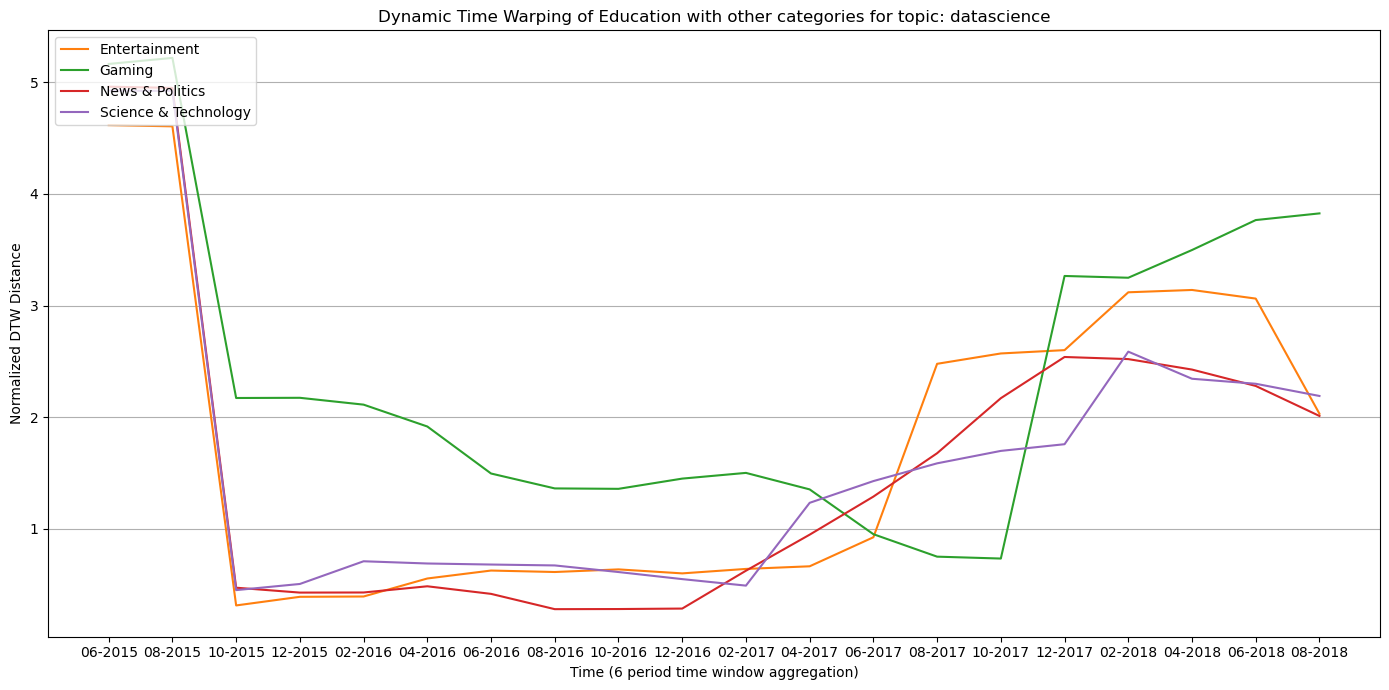

Figure 4: Dynamic Time Warping of Education accross differents categories over time looking at 12 months time window. 

We selected a rolling window size of 4 units (one year) based on the 3-month aggregation level of the time series. This choice aligns with natural annual cycles, capturing seasonality and periodic trends inherent in the data. A one-year window balances local variability and long-term patterns, ensuring that the rolling DTW distances reflect meaningful temporal dynamics while minimizing noise, making the results both robust and interpretable.

### Granger Causality Test explanation

Granger causality is a statistical method used to examine whether one time series can predict another, even when both variables are non-stationary. This approach has become a fundamental tool in time series analysis, particularly useful in understanding causal relationships between variables that vary over time. In simple terms, if past values of one time series contribute to the prediction of another, then it is said that the first series Granger-causes the second. This framework is especially relevant in cases where the goal is to explore causality between different categories of content creation on platforms like YouTube.

The process of Granger causality involves testing the null hypothesis that past values of the independent variable do not add significant predictive power to the dependent variable. By incorporating lagged values into a regression model, the test assesses whether the past values of one series provide additional information beyond what is already explained by the dependent variable alone. If the null hypothesis is rejected, it indicates a causal relationship between the two series, where past changes in one category influence the evolution of another.

[1] Barjasteh, I., Liu, Y., & Radha, H. (2014). Trending Videos: Measurement and Analysis. arXiv:1409.7733 [cs.SI]. https://doi.org/10.48550/arXiv.1409.7733

[2] Krishnamurthy, V., & Duan, Y. (2017). Dependence Structure Analysis Of Meta-level Metrics in YouTube Videos: A Vine Copula Approach. arXiv:1712.10232 [cs.SI]. https://doi.org/10.48550/arXiv.1712.10232

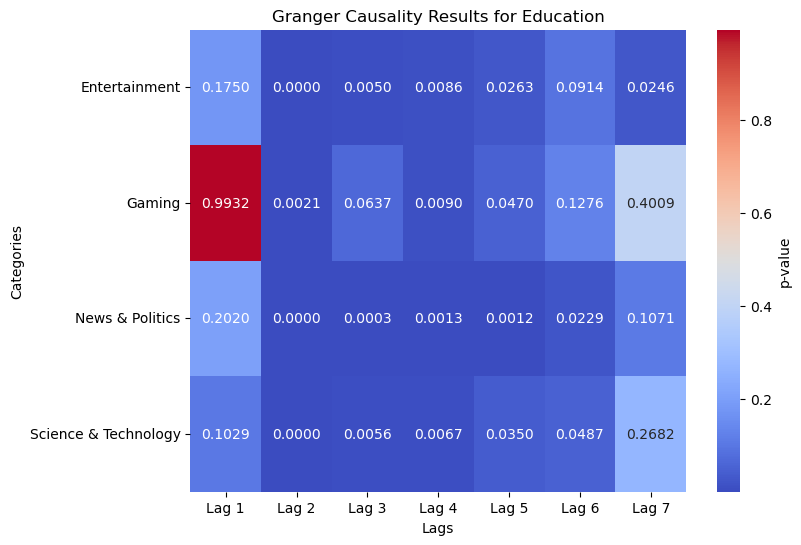

Figure 5: Granger Causality Test between Education and other categories for topic Data science.

The Granger causality analysis conducted between various content categories and the Education category on YouTube from 2015 to 2018 reveals significant insights into how past trends in different video categories influence educational content. Across various lags, categories such as Entertainment and Gaming demonstrate a strong immediate impact on educational content at lags 2 and 3, with p-values of 0.0000 and 0.0003, respectively. This suggests that trends in these categories significantly shape future content creation and engagement in education. Additionally, the Science & Technology category shows notable causality at lag 3 with a p-value of 0.0021, indicating its role in influencing educational content over time. These findings underscore the interplay between diverse content domains and their influence on educational discourse on the platform. As such, content from areas like entertainment, gaming, and specialized scientific fields plays a critical role in guiding the development of educational content and engagement on YouTube.